In [8]:
import torch
import utils

from environments.foggy_frozen_lake.utils import argument_actions
from environments.foggy_frozen_lake.FFL import FFL

from agents.orla import ORLABaseline
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


# Using ORLA to solve Foggy Frozen Lake (FFL)
This jupyter notebook showcases the use of [ORLA](https://github.com/omcandido/ORLA) to solve the FFL game, which is a variation of Frozen Lake (FL), an archetypal text-based game that comes with Gymnasium out-of-the-box.

In its original formulation, FL consists of a squared grid-like world where some cells are frozen (F) and others are holes (H). The agent needs to go from the start (S) in the upper left corner to the goal (G) in the lower right corner. Here is a text-based example of ORLA solving this game:

<center><img src="../imgs/FL.gif" width="350"></center>


## Frozen Lake with a twist
To make things more interesting, we introduce FFL, a variant of FL where the player can only observe its immediately neigbouring cells (as if some kind of dense fog shortened the player's sight) and the tile index it is at.
Here is a graphics-rendered example where the elf is the player and the red square around it represents observations:
<center><img src="../imgs/FFL.gif" width="350"></center>

This new formulation of the game is done to create a hiden state of the game so that the player needs both factual knowledge (derived from the current state of the world) and memory knowledge (derived from past states) to achieve a high score.



## An Argumentation Framework (AF) to play FFL

An argumentation framework is a set of arguments and attacks, where each argument recommends an action when all its associated conditions (premises) are satisfied at some point in the game. Every two attacks that recommend different actions attack each other.

With this in mind, we can come up with the following set of arguments:
```
-  U: go UP      if   cell-up     is   safe
-  D: go DOWN    if   cell-down   is   safe
-  L: go LEFT    if   cell-left   is   safe
-  R: go RIGHT   if   cell-right  is   safe
- nU: go UP      if   cell-up     is   safe   &   new
- nD: go DOWN    if   cell-down   is   safe   &   new
- nL: go LEFT    if   cell-left   is   safe   &   new
- nR: go RIGHT   if   cell-right  is   safe   &   new
```

Where arguments X promote exploring safe tiles and arguments nX promote exploring safe and unexplored squares. The complete AF can be represented through a graph, where the directed arrows represent attacks between arguments (i.e., A->B means A attacks B) would look like this:

<center><img src="../imgs/AF_FFL.png" width="300"></center>




## Learning a good ranking with ORLA

The goal of ORLA is to learn a ranking of the arguments such that the derived value-based argumentation framework (VAF) can be used as an inference engine by the agent to solve FFL.

ORLA is task-agnostic. This means that it just tries to maximise the reward of an MDP (see paper) regardless of what the specific task is. In this case, the task to solve is FFL. The rest of this notebook explains how to implement everything necessary to have ORLA solve FFL. If you want to apply ORLA to your own reinforcement learning task, follow along and create your own task-specific code.


#### Create a dictionary for your arguments and actions
ORLA needs a dictionary of the form ``{argument_name: action_name}``. This is what the arguments for ORLA look like in code:

In [9]:
argument_actions

{'U': <FLActions.UP: 3>,
 'L': <FLActions.LEFT: 0>,
 'R': <FLActions.RIGHT: 2>,
 'D': <FLActions.DOWN: 1>,
 'nD': <FLActions.DOWN: 1>,
 'nL': <FLActions.LEFT: 0>,
 'nR': <FLActions.RIGHT: 2>,
 'nU': <FLActions.UP: 3>}


#### Extend the ``Environment`` class
The interaction between the task and ORLA takes place via the abstract ``Environment`` class. You will need to inherit this class and implement your own methods:
- ``get_premises``: from the current observation and memory, which premises hold?
- ``get_arguments``: from the current premises, what arguments are applicable?
- ``update_memory``: how should memory be updated at each step?
- ``reset_memory``: how should memory be initialised?


### Training
Once the Arguments and the Environment are defined, we can instantiate an ORLA agent and train it for 10k of episodes. Note that we are sampling a new environment every episode, so ORLA will have to learn a policy for the distribution of FFL games with paramenters ``n`` and ``p``.



In [11]:
arguments = list(argument_actions.keys())
mode = utils.Mode.STRICT #whether the ranking should be strict or not
n_episodes = 10000
alpha_theta = 1e-4
alpha_w = utils.estimate_alpha_w(len(arguments), n_episodes)
orla = ORLABaseline(arguments, 1e-3, 1e-8, device, mode)

n=8 #map size
p=0.8 #probability of tile being frozen

batch_size = 8

returns = []
rankings_batch = []
probs_batch = []
returns_batch = []

t_episodes = tqdm(range(1, n_episodes+1))
for episode in t_episodes:
    env = FFL(argument_actions, n, p)

    orla.net.train()
    ranking, prob = orla.decode_ranking()
    score = env.play(ranking)
    returns.append(score)

    rankings_batch.append(ranking)
    probs_batch.append(prob)
    returns_batch.append(score)
    
    
    if len(rankings_batch) == batch_size:
        orla.learn(rankings_batch, probs_batch, returns_batch)
        rankings_batch = []
        probs_batch = []
        returns_batch = []
        past = 1000
        t_episodes.set_postfix({'avg': np.average(returns[-past:]), 'last': np.sum(returns[-batch_size:])/batch_size})


  0%|          | 0/10000 [00:00<?, ?it/s]

#### Learning curve
We see that ORLA has learned a pretty good policy (1 is the maximum attainable reward)

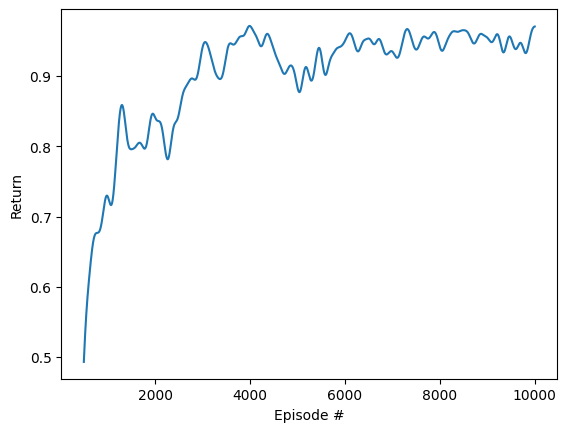

In [21]:
window = 100
data = pd.DataFrame(returns)
data = data.rolling(window).mean()
plt.plot(data)
plt.xlabel("Episode #")
plt.ylabel("Return")
plt.show()

#### Learned policy
The learned policy can be studied by looking at the learned ranking and the probabilities with which ORLA chose each of those arguments:



In [22]:
ranking, probs = orla.decode_ranking(True)
print("Learned ranking:", ranking)
print("    probabilities:", probs)

Learned ranking: [['nR'], ['nD'], ['L'], ['nU'], ['nL'], ['U'], ['D'], ['R']]
    probabilities: tensor([0.9989, 0.9988, 0.5973, 0.9326, 0.9723, 0.8451, 0.9572, 1.0000],
       grad_fn=<StackBackward0>)
